# Setup enviorment

In [1]:
%cd ..

/home/datascience/TOP 10 Municipalities Models


In [2]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [3]:
""" Read Dataset:"""

embeddings = 'Embeddings/variational_autoencoder_Per_Band/224_band4.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T = 0
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [4]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

### Train Test split

In [5]:
train_df = []
test_df = []

for i in range(len(dengue_df)):
    train_df_aux, test_df_aux = train_test_split(dengue_df[i], train_percentage)
    train_df.append(train_df_aux)
    test_df.append(test_df_aux)
#test_df

The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)


### Normalize features

In [6]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities)
test_df = pd.concat(test_df, keys=Municipalities)

In [7]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0         1         2         3         4         5  \
41001 201546 -0.171496 -0.069408 -0.724054 -0.131032  0.275964  0.492442   
      201547 -0.032085  0.348385 -0.085066  0.280988  0.236845 -0.416520   
      201548 -0.114297 -0.529947 -0.164663 -0.368868  0.201132 -0.419668   
      201549  0.026347 -0.278896  0.053199 -0.068414  0.064766  0.058644   
      201550  0.185937 -0.032604 -0.060569 -0.138244  0.390583  0.833096   

                     6         7         8         9  ...      1015      1016  \
41001 201546 -0.175494  0.216015 -0.332785 -0.326948  ... -0.037812  0.136233   
      201547 -0.960457 -0.368136  0.011551  0.126177  ...  0.135463  0.465546   
      201548  0.199142  0.045901  0.084853 -0.558179  ... -0.235429 -0.502080   
      201549  0.173566 -0.336297 -0.228506 -0.258044  ... -0.215027  0.238450   
      201550 -0.291163 -0.000716 -0.149281  0.065728  ... -0.360305  0.246751   

                  1017      1018      1019      1020      1021      1022  \
41001 201546  0.463218 -0.241320 -0.524814  0.020816 -0.198965 -0.471143   
      201547 -0.300449  0.269523  0.191744  0.369473  0.026871 -0.307074   
      201548  0.252961 -0.242919  0.318038 -0.113445  0.198234 -0.079587   
      201549 -0.256264  0.453023 -0.530433  0.161037  0.668699  0.159926   
      201550 -0.511378  0.212745  0.035890 -0.041802 -0.091828  0.146182   

                  1023    Labels  
41001 201546 -0.166923 -0.861740  
      201547  0.046181 -0.854589  
      201548  0.295928 -0.856973  
      201549 -0.001921 -0.856973  
      201550 -0.149513 -0.823600  

[5 rows x 1025 columns]

In [8]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

test_df[1].head()

0         1         2         3         4         5  \
41001 201820  0.730323  0.062757 -0.594704  0.223811 -0.482528 -0.173403   
      201821 -0.167166 -0.162303  0.156954 -0.119531 -0.173932 -0.172264   
      201822  0.100136 -0.051730 -0.454536 -0.060220  0.718308 -0.210365   
      201823 -0.140060 -0.179463 -0.346650  0.128750  0.196326  0.540115   
      201824 -0.415249  0.234436 -0.155037  0.165834  0.380979  0.149695   

                     6         7         8         9  ...      1015      1016  \
41001 201820 -0.014873 -0.555330 -0.306882  0.057438  ...  0.646330  0.255581   
      201821 -0.351838  0.161949  0.147018  0.020288  ... -0.031405  0.342571   
      201822 -0.162143  0.549078  0.557929 -0.156333  ...  0.262978  0.299797   
      201823 -0.111850 -0.162490  0.174741  0.025184  ... -0.023828  0.116389   
      201824  0.000088  0.422106 -0.142515 -0.418239  ... -0.609689 -0.427740   

                  1017      1018      1019      1020      1021      1022  \
41001 201820 -0.017182  0.277301  0.054272  0.573571 -0.253010  0.119001   
      201821  0.241549 -0.403147 -0.062745  0.152630 -0.141184  0.118016   
      201822 -0.209064  0.534755 -0.163714  0.046984 -0.092062  0.203199   
      201823  0.008151  0.128728  0.201175  0.735946 -0.396541 -0.611070   
      201824  0.458867 -0.109875  0.150765  0.068276  0.128139  0.030658   

                  1023    Labels  
41001 201820  0.187571 -0.949940  
      201821  0.303227 -0.961859  
      201822 -0.268789 -0.940405  
      201823  0.301484 -0.961859  
      201824 -0.105399 -0.954708  

[5 rows x 1025 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [9]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(130, 1025)

### Merge train data

In [10]:
# Merge:
train = pd.concat(train, keys=Municipalities)
test = pd.concat(test, keys=Municipalities)

In [11]:
train.shape

(1300, 1025)

### Features and Labels Set

In [12]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1300, 1024)
The shape of the labels is (1300, 1)
Test:
The shape of the features is (330, 1024)
The shape of the labels is (330, 1)


In [13]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

# 2. Model

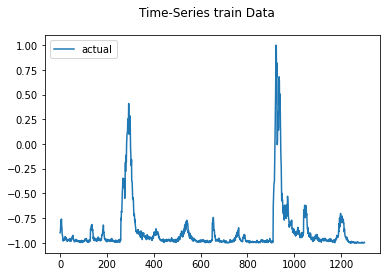

2023-03-14 14:15:06.688503: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-14 14:15:06.688653: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-14 14:15:06.688683: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9e0b1a08816a): /proc/driver/nvidia/version does not exist
2023-03-14 14:15:06.688899: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 14:15:06.775592: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Test MAE: 41.090
Test RMSE: 52.240
Test sMAPE: 98.111
Test R Squared: -1.824
{'mae': 41.09049769820589, 'rmse': 52.24043043750003, 'smape': 98.110886692543, 'r2': -1.8239401947166303}


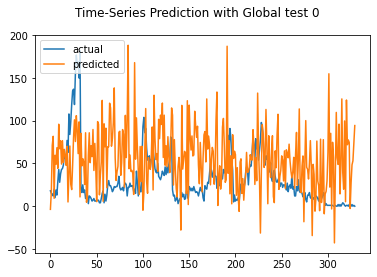

Test MAE: 60.597
Test RMSE: 74.473
Test sMAPE: 110.859
Test R Squared: -4.739
{'mae': 60.59662605307319, 'rmse': 74.47292649818102, 'smape': 110.85910716746514, 'r2': -4.739034588671849}


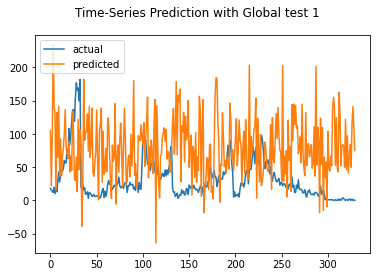

Test MAE: 45.430
Test RMSE: 54.715
Test sMAPE: 100.469
Test R Squared: -2.098
{'mae': 45.43021490691286, 'rmse': 54.71513361220757, 'smape': 100.4689821974052, 'r2': -2.0978253535405864}


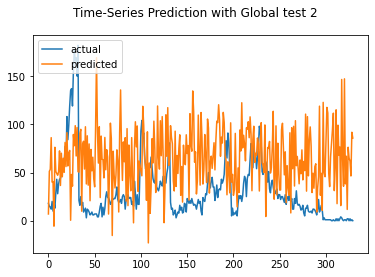

Test MAE: 51.712
Test RMSE: 60.647
Test sMAPE: 105.138
Test R Squared: -2.806
{'mae': 51.71209251230413, 'rmse': 60.646593413614674, 'smape': 105.13783512340339, 'r2': -2.8058776605456517}


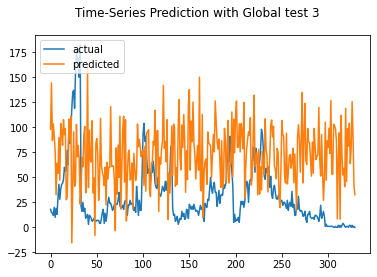

Test MAE: 66.831
Test RMSE: 75.133
Test sMAPE: 113.914
Test R Squared: -4.841
{'mae': 66.83149291818792, 'rmse': 75.13278573663318, 'smape': 113.9139051443779, 'r2': -4.841185319755552}


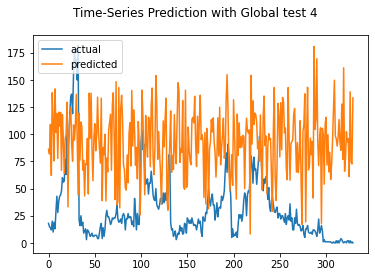

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 52.232
Test RMSE: 64.693
Test sMAPE: 107.660
Test R Squared: -3.331
{'mae': 52.23201909480673, 'rmse': 64.69308860800464, 'smape': 107.66035651971968, 'r2': -3.3306967449164997}


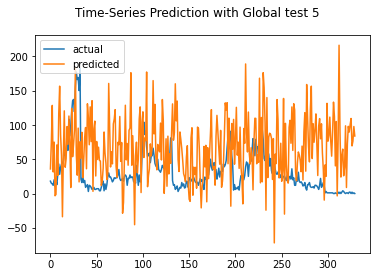

Test MAE: 55.120
Test RMSE: 63.357
Test sMAPE: 107.015
Test R Squared: -3.154
{'mae': 55.12042719089624, 'rmse': 63.356581646783965, 'smape': 107.01522561055754, 'r2': -3.1536077018191753}


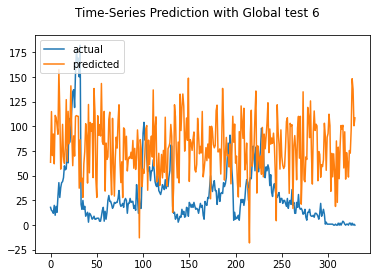

Test MAE: 51.166
Test RMSE: 59.151
Test sMAPE: 106.683
Test R Squared: -2.621
{'mae': 51.16609531153332, 'rmse': 59.15146233244942, 'smape': 106.68342971553335, 'r2': -2.6205368571476004}


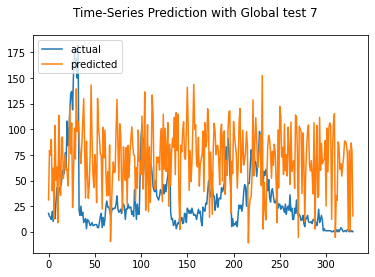

Test MAE: 41.959
Test RMSE: 51.453
Test sMAPE: 99.333
Test R Squared: -1.739
{'mae': 41.95894202445493, 'rmse': 51.45322878672366, 'smape': 99.33299560569223, 'r2': -1.7394745311425575}


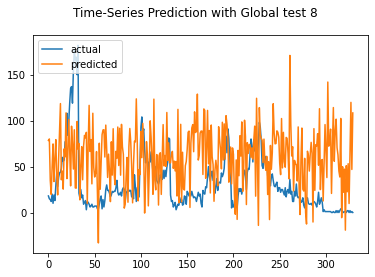

Test MAE: 35.274
Test RMSE: 44.439
Test sMAPE: 97.037
Test R Squared: -1.043
{'mae': 35.27423967574582, 'rmse': 44.43919514362742, 'smape': 97.03659938630146, 'r2': -1.0434987245155503}


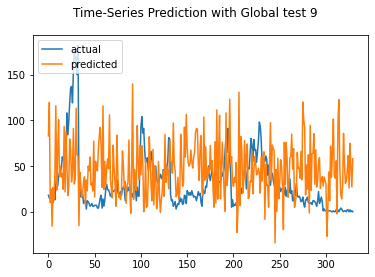

Test MAE: 60.285
Test RMSE: 67.331
Test sMAPE: 112.037
Test R Squared: -3.691
{'mae': 60.28465792916038, 'rmse': 67.33131206744933, 'smape': 112.03685813825851, 'r2': -3.6911158335617413}


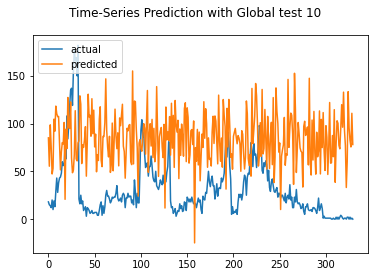

Test MAE: 52.038
Test RMSE: 61.222
Test sMAPE: 106.051
Test R Squared: -2.878
{'mae': 52.038311844522305, 'rmse': 61.22196272895599, 'smape': 106.05073451646648, 'r2': -2.8784348354339215}


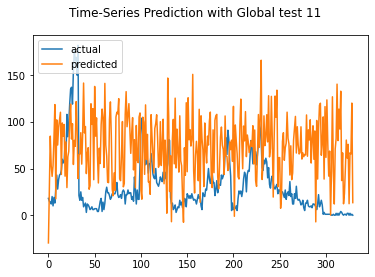

Test MAE: 43.502
Test RMSE: 52.712
Test sMAPE: 101.763
Test R Squared: -1.875
{'mae': 43.50166331692176, 'rmse': 52.71191363732534, 'smape': 101.7629134681743, 'r2': -1.8751437794581758}


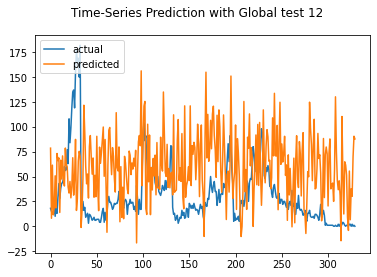

Test MAE: 37.396
Test RMSE: 47.332
Test sMAPE: 100.146
Test R Squared: -1.318
{'mae': 37.395752722205536, 'rmse': 47.33228799577791, 'smape': 100.1460304061876, 'r2': -1.318232544309534}


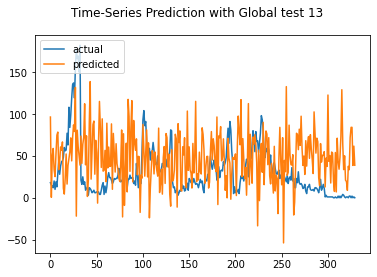

Test MAE: 47.930
Test RMSE: 57.885
Test sMAPE: 104.606
Test R Squared: -2.467
{'mae': 47.929908937847976, 'rmse': 57.885153868171905, 'smape': 104.60569272516234, 'r2': -2.4671799757571873}


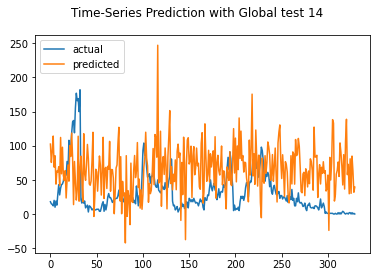

Test MAE: 54.137
Test RMSE: 65.333
Test sMAPE: 105.099
Test R Squared: -3.417
{'mae': 54.13674396023606, 'rmse': 65.3325580947181, 'smape': 105.09946832154361, 'r2': -3.4167348526871315}


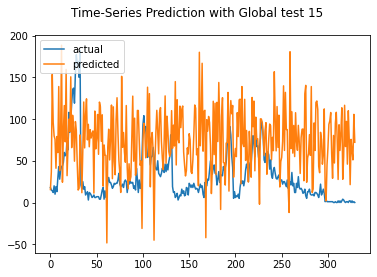

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 37.846
Test RMSE: 48.733
Test sMAPE: 112.849
Test R Squared: -1.457
{'mae': 37.84577349117308, 'rmse': 48.73264985719332, 'smape': 112.84915082907001, 'r2': -1.4574350914562673}


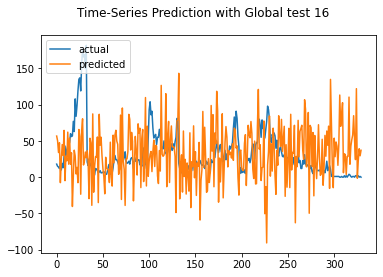

Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Test MAE: 50.288
Test RMSE: 63.408
Test sMAPE: 113.845
Test R Squared: -3.160
{'mae': 50.28770686677008, 'rmse': 63.40839569559243, 'smape': 113.84451235326493, 'r2': -3.160404256490077}


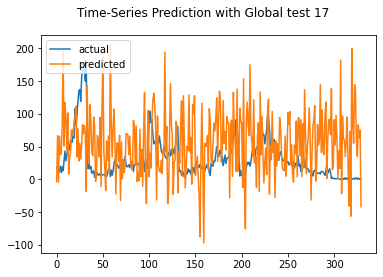

Test MAE: 54.216
Test RMSE: 62.627
Test sMAPE: 106.110
Test R Squared: -3.058
{'mae': 54.21592976107742, 'rmse': 62.62699256859855, 'smape': 106.10977638383342, 'r2': -3.0584959346166904}


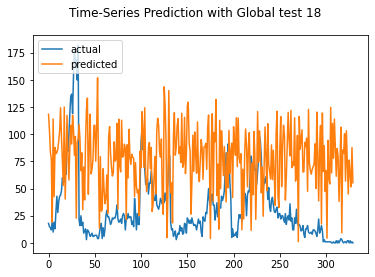

Test MAE: 52.770
Test RMSE: 63.135
Test sMAPE: 106.799
Test R Squared: -3.125
{'mae': 52.770278740290436, 'rmse': 63.13454770270085, 'smape': 106.7993336672322, 'r2': -3.124545973043393}


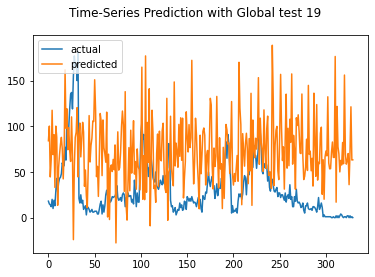

Test MAE: 34.912
Test RMSE: 45.194
Test sMAPE: 98.198
Test R Squared: -1.113
{'mae': 34.91234548109951, 'rmse': 45.19364641711419, 'smape': 98.19795822666336, 'r2': -1.11347331449283}


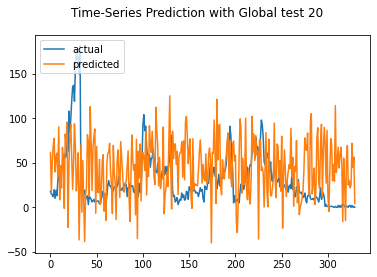

Test MAE: 41.206
Test RMSE: 50.117
Test sMAPE: 105.712
Test R Squared: -1.599
{'mae': 41.20574907245058, 'rmse': 50.116541069941135, 'smape': 105.71213140276902, 'r2': -1.5989874377451772}


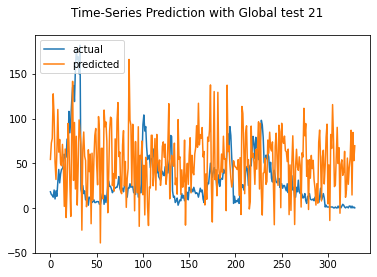

Test MAE: 50.085
Test RMSE: 58.630
Test sMAPE: 103.245
Test R Squared: -2.557
{'mae': 50.08479019800822, 'rmse': 58.62997097352432, 'smape': 103.24477626185106, 'r2': -2.5569794819579434}


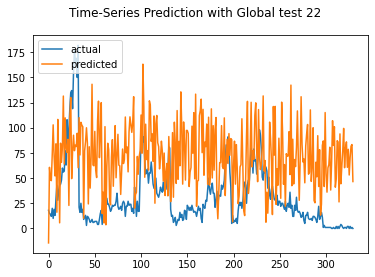

Test MAE: 44.442
Test RMSE: 53.376
Test sMAPE: 98.982
Test R Squared: -1.948
{'mae': 44.441843454043074, 'rmse': 53.375923578480915, 'smape': 98.98191268321409, 'r2': -1.9480361675440871}


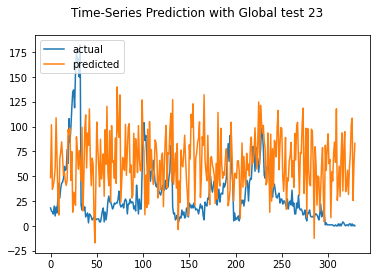

Test MAE: 45.326
Test RMSE: 55.760
Test sMAPE: 102.043
Test R Squared: -2.217
{'mae': 45.325757818149796, 'rmse': 55.75965315018869, 'smape': 102.04348138502863, 'r2': -2.217230141465727}


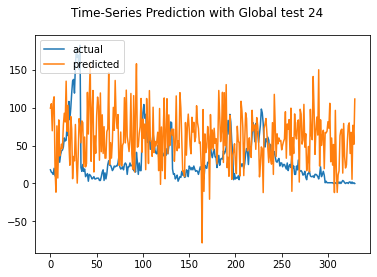

Test MAE: 40.086
Test RMSE: 49.603
Test sMAPE: 97.234
Test R Squared: -1.546
{'mae': 40.08649299144745, 'rmse': 49.602778493285896, 'smape': 97.23444408567667, 'r2': -1.5459742677278419}


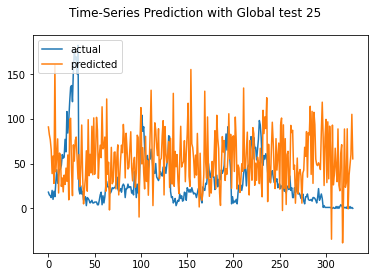

Test MAE: 43.040
Test RMSE: 52.664
Test sMAPE: 100.434
Test R Squared: -1.870
{'mae': 43.04039014126315, 'rmse': 52.66374560457546, 'smape': 100.4344901138129, 'r2': -1.8698915799367684}


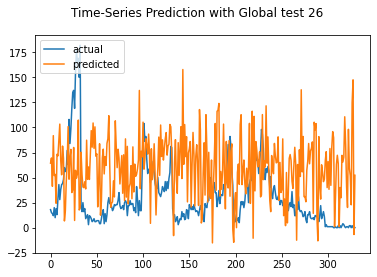

Test MAE: 61.518
Test RMSE: 69.468
Test sMAPE: 111.287
Test R Squared: -3.994
{'mae': 61.518297628922895, 'rmse': 69.46810461883074, 'smape': 111.28699483075849, 'r2': -3.993590222706965}


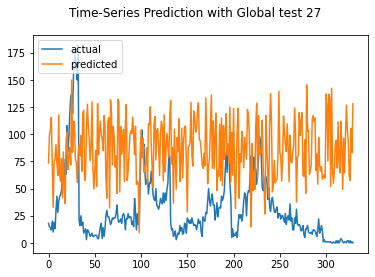

Test MAE: 51.228
Test RMSE: 59.154
Test sMAPE: 106.107
Test R Squared: -2.621
{'mae': 51.22814760190068, 'rmse': 59.15429665736063, 'smape': 106.10673537484587, 'r2': -2.620883831618061}


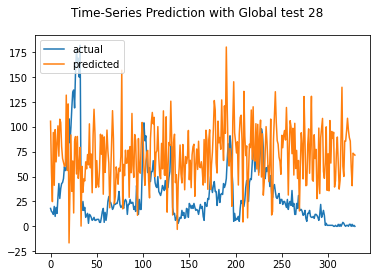

Test MAE: 50.826
Test RMSE: 59.139
Test sMAPE: 106.598
Test R Squared: -2.619
{'mae': 50.825595644297024, 'rmse': 59.13940055592514, 'smape': 106.59845000081674, 'r2': -2.619060455642489}


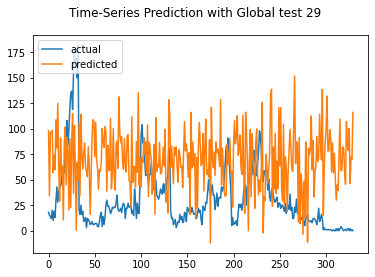

Test MAE: 49.794
Test RMSE: 58.346
Test sMAPE: 102.471
Test R Squared: -2.523
{'mae': 49.79356246717048, 'rmse': 58.34575190262446, 'smape': 102.47142745818753, 'r2': -2.522576906604834}


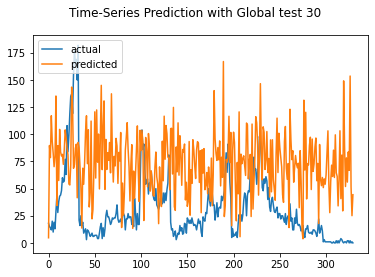

Test MAE: 39.290
Test RMSE: 47.927
Test sMAPE: 100.227
Test R Squared: -1.377
{'mae': 39.28975723349687, 'rmse': 47.926707819224625, 'smape': 100.22688508720803, 'r2': -1.3768249439846163}


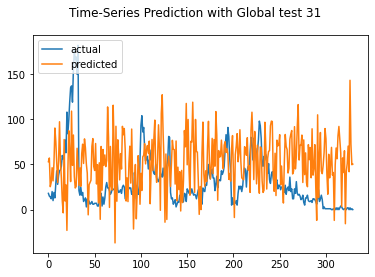

Test MAE: 53.886
Test RMSE: 62.934
Test sMAPE: 105.569
Test R Squared: -3.098
{'mae': 53.88575496529088, 'rmse': 62.93390638928543, 'smape': 105.56926764712524, 'r2': -3.098372051811624}


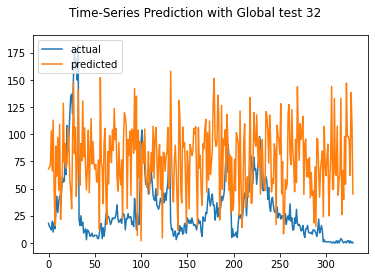

Test MAE: 58.339
Test RMSE: 67.359
Test sMAPE: 110.228
Test R Squared: -3.695
{'mae': 58.33944248195851, 'rmse': 67.35924863521973, 'smape': 110.22845740629577, 'r2': -3.6950094414314796}


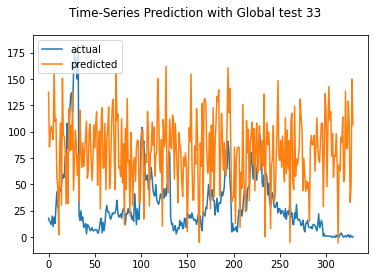

Test MAE: 31.138
Test RMSE: 40.965
Test sMAPE: 92.923
Test R Squared: -0.736
{'mae': 31.137689473412255, 'rmse': 40.96473715595588, 'smape': 92.92325333109632, 'r2': -0.7364502571567322}


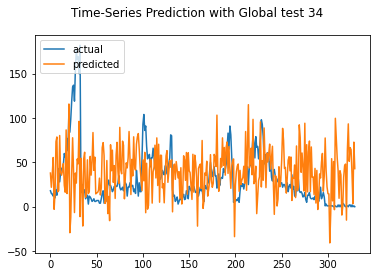

Test MAE: 53.174
Test RMSE: 62.131
Test sMAPE: 106.805
Test R Squared: -2.994
{'mae': 53.17401013843941, 'rmse': 62.13077616243932, 'smape': 106.8053671768411, 'r2': -2.9944368513073707}


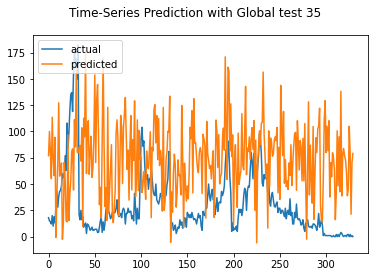

Test MAE: 49.296
Test RMSE: 57.391
Test sMAPE: 105.317
Test R Squared: -2.408
{'mae': 49.29587707989143, 'rmse': 57.391160217377916, 'smape': 105.31741749760174, 'r2': -2.4082544521450866}


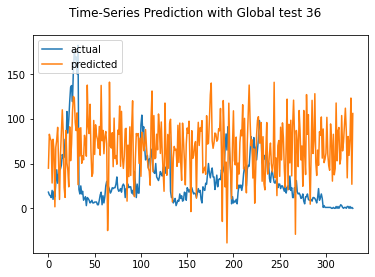

Test MAE: 72.011
Test RMSE: 79.966
Test sMAPE: 117.421
Test R Squared: -5.617
{'mae': 72.01053567077174, 'rmse': 79.96649713507887, 'smape': 117.42062430113442, 'r2': -5.616954475618857}


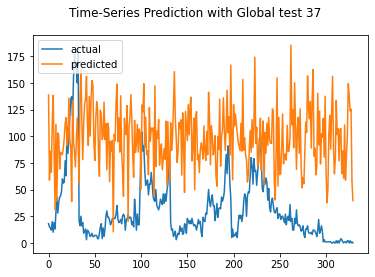

Test MAE: 32.235
Test RMSE: 43.065
Test sMAPE: 105.445
Test R Squared: -0.919
{'mae': 32.235186437223895, 'rmse': 43.064797149865235, 'smape': 105.44513439102768, 'r2': -0.919052311855822}


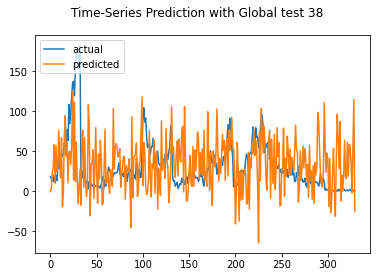

Test MAE: 45.834
Test RMSE: 54.519
Test sMAPE: 104.995
Test R Squared: -2.076
{'mae': 45.83387073007497, 'rmse': 54.51932624143852, 'smape': 104.99516986334244, 'r2': -2.07569284180998}


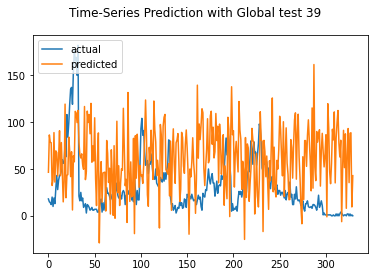

Test MAE: 49.669
Test RMSE: 57.342
Test sMAPE: 105.643
Test R Squared: -2.402
{'mae': 49.669052769921045, 'rmse': 57.34190570553771, 'smape': 105.64316597461716, 'r2': -2.4024068661154026}


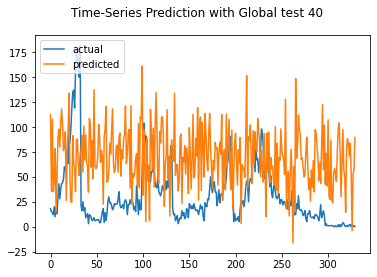

Test MAE: 48.176
Test RMSE: 57.622
Test sMAPE: 105.399
Test R Squared: -2.436
{'mae': 48.176143390843365, 'rmse': 57.621986248468936, 'smape': 105.3987660479972, 'r2': -2.435725439606226}


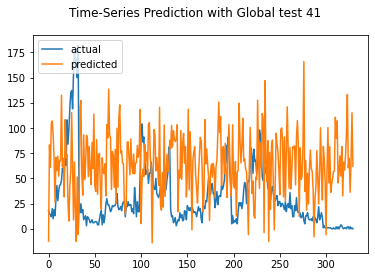

Test MAE: 52.696
Test RMSE: 61.556
Test sMAPE: 105.083
Test R Squared: -2.921
{'mae': 52.696267798633286, 'rmse': 61.55556070127305, 'smape': 105.08259253550204, 'r2': -2.9208171111842116}


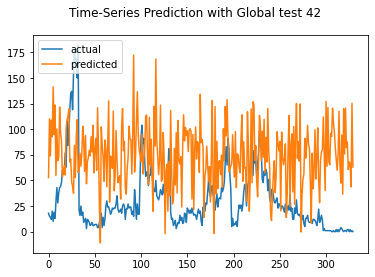

Test MAE: 39.847
Test RMSE: 50.793
Test sMAPE: 100.138
Test R Squared: -1.670
{'mae': 39.84702839454015, 'rmse': 50.79282127943032, 'smape': 100.13793991919131, 'r2': -1.6696029545759434}


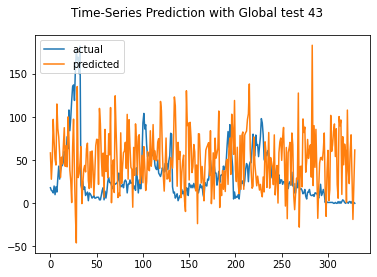

Test MAE: 45.181
Test RMSE: 53.024
Test sMAPE: 101.610
Test R Squared: -1.909
{'mae': 45.18147615609747, 'rmse': 53.024367610474904, 'smape': 101.60964013549393, 'r2': -1.9093300783487281}


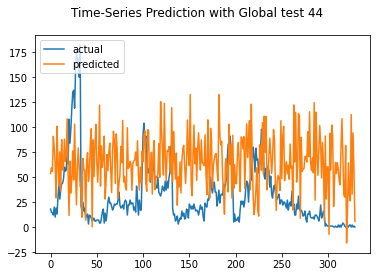

Test MAE: 54.238
Test RMSE: 62.985
Test sMAPE: 108.828
Test R Squared: -3.105
{'mae': 54.2377698320331, 'rmse': 62.98512082492158, 'smape': 108.82755947215759, 'r2': -3.1050451229222586}


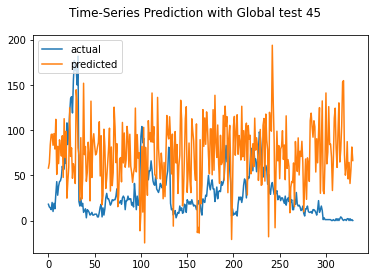

Test MAE: 52.143
Test RMSE: 61.311
Test sMAPE: 106.530
Test R Squared: -2.890
{'mae': 52.14338559959874, 'rmse': 61.31057856036116, 'smape': 106.52990245447134, 'r2': -2.889670655065252}


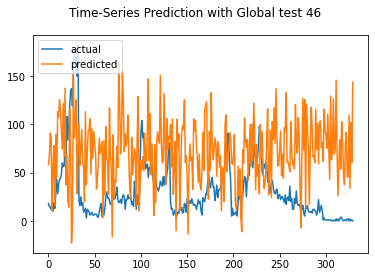

Test MAE: 50.105
Test RMSE: 59.579
Test sMAPE: 105.146
Test R Squared: -2.673
{'mae': 50.104631979537736, 'rmse': 59.57916276238483, 'smape': 105.14604600380108, 'r2': -2.673083435646649}


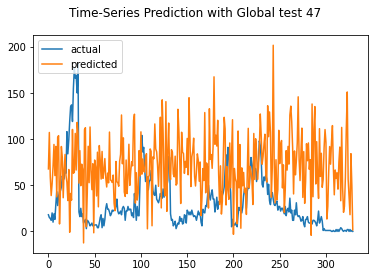

Test MAE: 59.301
Test RMSE: 68.919
Test sMAPE: 109.736
Test R Squared: -3.915
{'mae': 59.30103695320361, 'rmse': 68.91942088917568, 'smape': 109.73592161253539, 'r2': -3.9150194494005204}


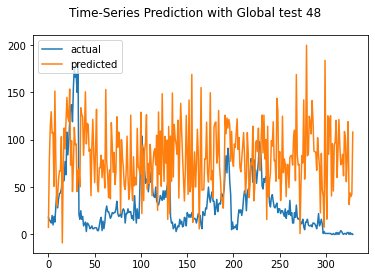

Test MAE: 37.774
Test RMSE: 48.056
Test sMAPE: 110.593
Test R Squared: -1.390
{'mae': 37.773538614222495, 'rmse': 48.0560662993575, 'smape': 110.59283104322853, 'r2': -1.3896727864789944}


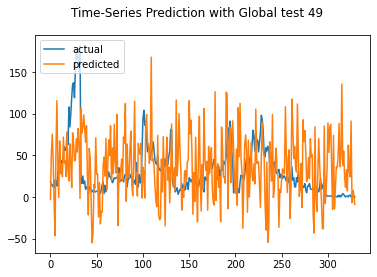

Test MAE: 43.004
Test RMSE: 50.551
Test sMAPE: 100.293
Test R Squared: -1.644
{'mae': 43.00356232036244, 'rmse': 50.55071603050614, 'smape': 100.29315468551854, 'r2': -1.6442141492385294}


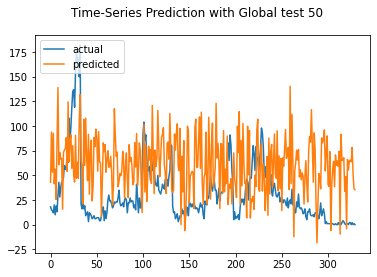

Test MAE: 40.211
Test RMSE: 50.638
Test sMAPE: 100.994
Test R Squared: -1.653
{'mae': 40.210521923953834, 'rmse': 50.63830357929611, 'smape': 100.99355201056572, 'r2': -1.653385171808838}


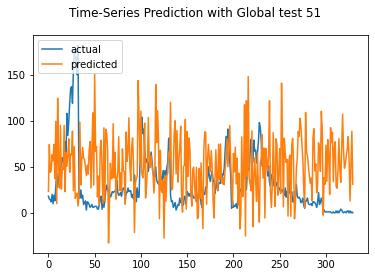

Test MAE: 48.567
Test RMSE: 57.873
Test sMAPE: 103.310
Test R Squared: -2.466
{'mae': 48.56738443374634, 'rmse': 57.87275058883025, 'smape': 103.30952997383709, 'r2': -2.4656942823960204}


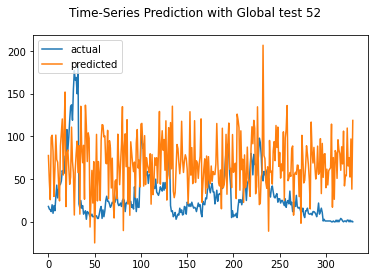

Test MAE: 59.185
Test RMSE: 69.372
Test sMAPE: 109.155
Test R Squared: -3.980
{'mae': 59.18490829251029, 'rmse': 69.37164359786587, 'smape': 109.15500850366675, 'r2': -3.9797319956275423}


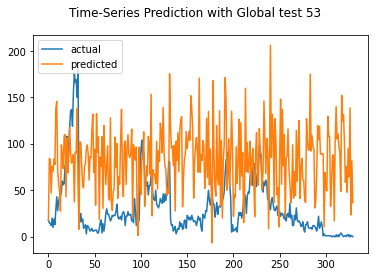

Test MAE: 42.412
Test RMSE: 50.770
Test sMAPE: 99.444
Test R Squared: -1.667
{'mae': 42.41166500051816, 'rmse': 50.7704320154392, 'smape': 99.44410111237909, 'r2': -1.6672499735634845}


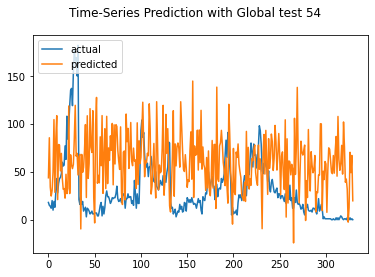

Test MAE: 62.469
Test RMSE: 70.962
Test sMAPE: 111.356
Test R Squared: -4.211
{'mae': 62.46919890895035, 'rmse': 70.96208769710198, 'smape': 111.35586312665544, 'r2': -4.21068439767595}


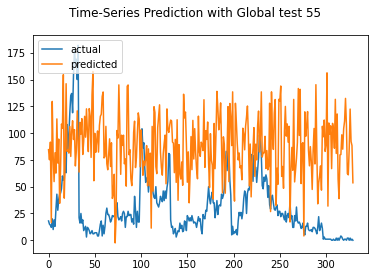

Test MAE: 51.018
Test RMSE: 59.040
Test sMAPE: 105.774
Test R Squared: -2.607
{'mae': 51.0183507178769, 'rmse': 59.040048086881725, 'smape': 105.77438171828732, 'r2': -2.606910837581713}


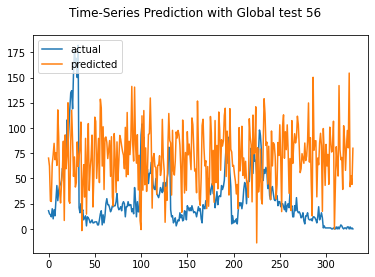

Test MAE: 39.877
Test RMSE: 48.983
Test sMAPE: 100.003
Test R Squared: -1.483
{'mae': 39.87696275241447, 'rmse': 48.983084507811476, 'smape': 100.00256439766912, 'r2': -1.482757261474994}


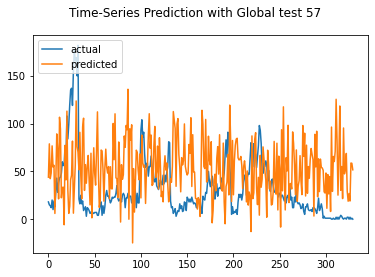

Test MAE: 57.271
Test RMSE: 66.426
Test sMAPE: 108.294
Test R Squared: -3.566
{'mae': 57.27067143772587, 'rmse': 66.42641873182265, 'smape': 108.29406265159871, 'r2': -3.565871443023349}


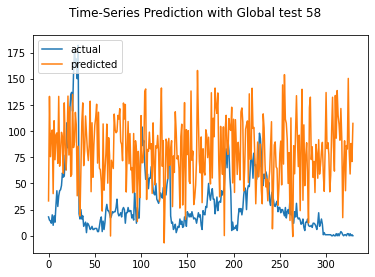

Test MAE: 54.063
Test RMSE: 62.488
Test sMAPE: 106.145
Test R Squared: -3.041
{'mae': 54.06260851368759, 'rmse': 62.48808165235725, 'smape': 106.14478694226976, 'r2': -3.0405118633280814}


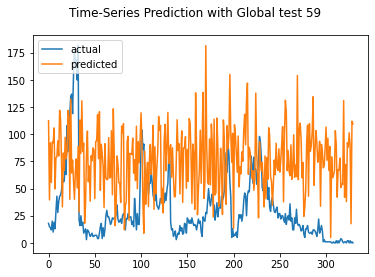

Test MAE: 40.649
Test RMSE: 48.945
Test sMAPE: 98.988
Test R Squared: -1.479
{'mae': 40.64858445778037, 'rmse': 48.94468421472038, 'smape': 98.98781564947829, 'r2': -1.4788660718074547}


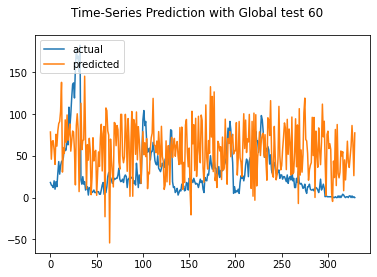

Test MAE: 42.405
Test RMSE: 51.202
Test sMAPE: 102.051
Test R Squared: -1.713
{'mae': 42.40536408207633, 'rmse': 51.202015051676334, 'smape': 102.0511208112193, 'r2': -1.7127895732874716}


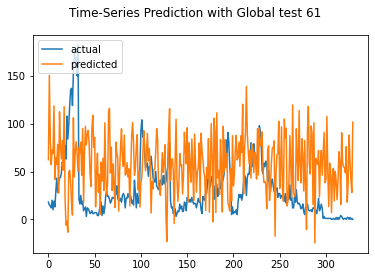

Test MAE: 43.256
Test RMSE: 54.651
Test sMAPE: 104.014
Test R Squared: -2.091
{'mae': 43.255863937825865, 'rmse': 54.65145110751268, 'smape': 104.01377215450042, 'r2': -2.0906184818806}


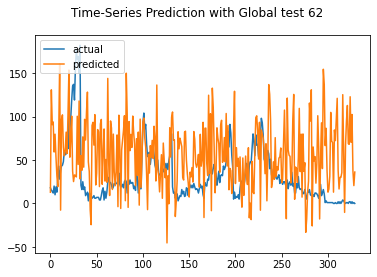

Test MAE: 56.152
Test RMSE: 65.210
Test sMAPE: 108.098
Test R Squared: -3.400
{'mae': 56.15241112167185, 'rmse': 65.21000474925704, 'smape': 108.09778264451725, 'r2': -3.400180229213187}


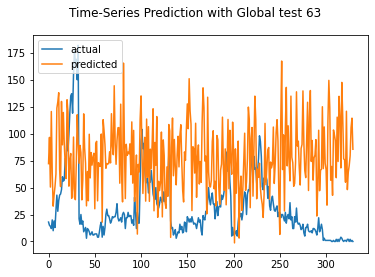

Test MAE: 39.647
Test RMSE: 48.112
Test sMAPE: 96.592
Test R Squared: -1.395
{'mae': 39.64658563805349, 'rmse': 48.11204918597657, 'smape': 96.59159807971368, 'r2': -1.3952437253798098}


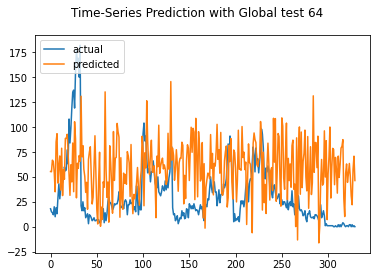

Test MAE: 60.009
Test RMSE: 68.896
Test sMAPE: 110.410
Test R Squared: -3.912
{'mae': 60.00889062014493, 'rmse': 68.89560208005592, 'smape': 110.41040620192152, 'r2': -3.9116227383232642}


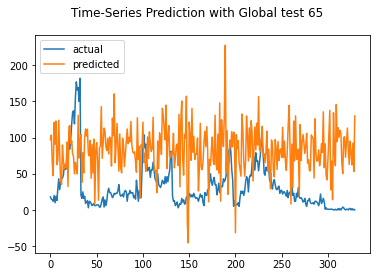

Test MAE: 49.029
Test RMSE: 57.505
Test sMAPE: 103.262
Test R Squared: -2.422
{'mae': 49.02947108528831, 'rmse': 57.504762281212436, 'smape': 103.26235573777161, 'r2': -2.421760641664753}


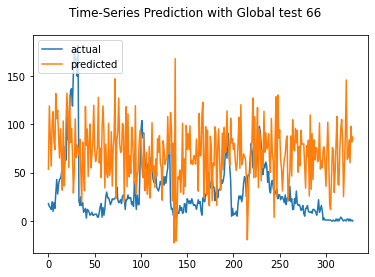

Test MAE: 39.985
Test RMSE: 50.764
Test sMAPE: 105.680
Test R Squared: -1.667
{'mae': 39.984732232129936, 'rmse': 50.763554364008534, 'smape': 105.6801577654988, 'r2': -1.6665273808121914}


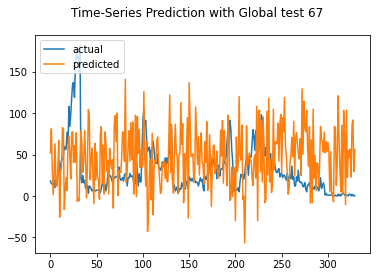

Test MAE: 48.781
Test RMSE: 58.243
Test sMAPE: 106.252
Test R Squared: -2.510
{'mae': 48.78113236571803, 'rmse': 58.24335463606903, 'smape': 106.25182751771882, 'r2': -2.510223454398444}


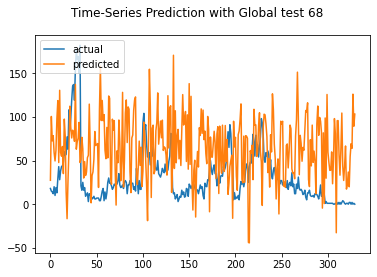

Test MAE: 45.458
Test RMSE: 53.626
Test sMAPE: 101.909
Test R Squared: -1.976
{'mae': 45.457644149570754, 'rmse': 53.62601667842099, 'smape': 101.90918288916257, 'r2': -1.9757269586989845}


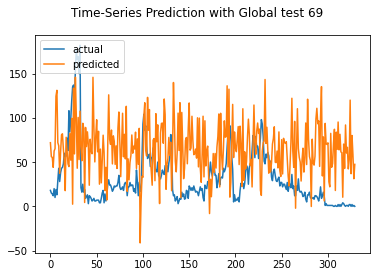

Test MAE: 44.532
Test RMSE: 53.421
Test sMAPE: 100.491
Test R Squared: -1.953
{'mae': 44.53224732514584, 'rmse': 53.42119609561218, 'smape': 100.49137919976395, 'r2': -1.9530392329819986}


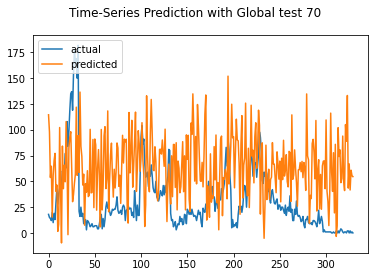

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Test MAE: 54.560
Test RMSE: 66.302
Test sMAPE: 116.305
Test R Squared: -3.549
{'mae': 54.55976499382294, 'rmse': 66.30193538783014, 'smape': 116.30497945971993, 'r2': -3.5487745593442988}


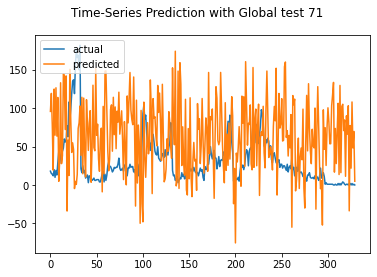

Test MAE: 46.524
Test RMSE: 56.249
Test sMAPE: 100.503
Test R Squared: -2.274
{'mae': 46.52386888753284, 'rmse': 56.248960615865464, 'smape': 100.50262088072166, 'r2': -2.2739421810087936}


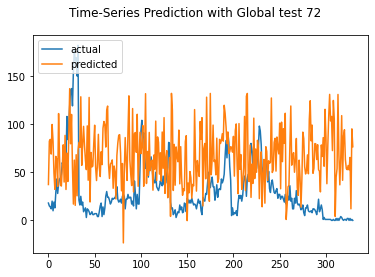

Test MAE: 58.851
Test RMSE: 68.984
Test sMAPE: 112.246
Test R Squared: -3.924
{'mae': 58.850608671072756, 'rmse': 68.98393654939761, 'smape': 112.24554056533997, 'r2': -3.924225682934714}


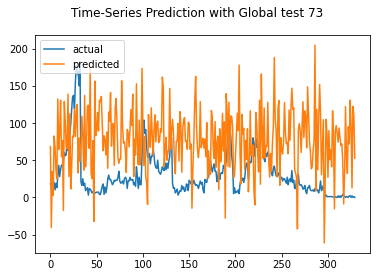

Test MAE: 56.713
Test RMSE: 65.527
Test sMAPE: 109.164
Test R Squared: -3.443
{'mae': 56.713282276644854, 'rmse': 65.52694194484397, 'smape': 109.16353464301962, 'r2': -3.4430561589362148}


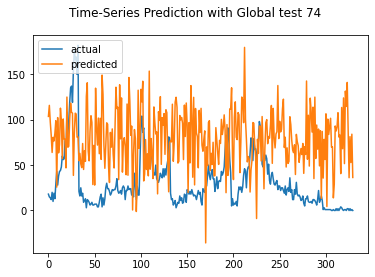

Test MAE: 35.959
Test RMSE: 45.455
Test sMAPE: 94.291
Test R Squared: -1.138
{'mae': 35.95901868776841, 'rmse': 45.455235105458414, 'smape': 94.29055032948244, 'r2': -1.1380104246019065}


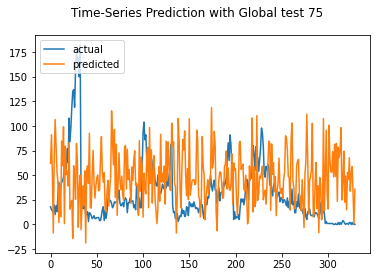

Test MAE: 43.185
Test RMSE: 53.439
Test sMAPE: 107.429
Test R Squared: -1.955
{'mae': 43.18461898113742, 'rmse': 53.43867725928416, 'smape': 107.42869287147663, 'r2': -1.9549722113587844}


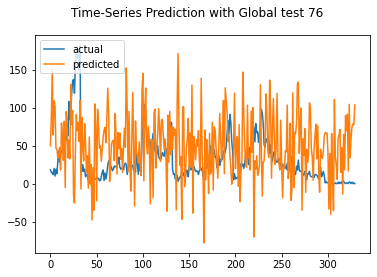

Test MAE: 50.483
Test RMSE: 59.190
Test sMAPE: 105.151
Test R Squared: -2.625
{'mae': 50.48290568897218, 'rmse': 59.19037349727931, 'smape': 105.15149551195417, 'r2': -2.6253017653224915}


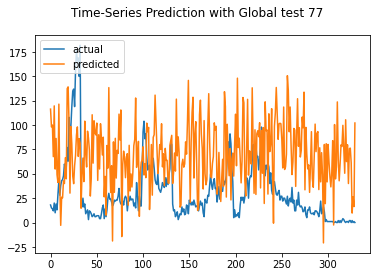

Test MAE: 46.668
Test RMSE: 55.965
Test sMAPE: 103.886
Test R Squared: -2.241
{'mae': 46.668288704481995, 'rmse': 55.965220871872745, 'smape': 103.88556062922783, 'r2': -2.2409956328249336}


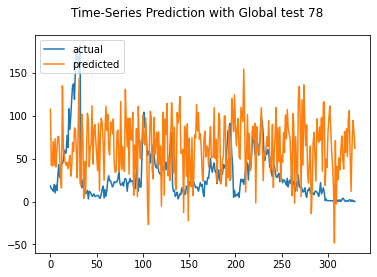

Test MAE: 36.182
Test RMSE: 46.826
Test sMAPE: 108.160
Test R Squared: -1.269
{'mae': 36.18218142823739, 'rmse': 46.825830856576914, 'smape': 108.16044345264355, 'r2': -1.2688876216669218}


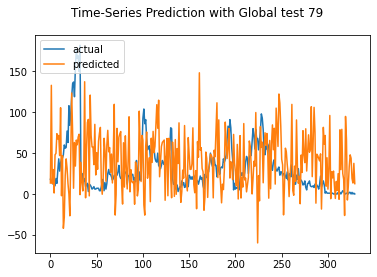

Test MAE: 58.974
Test RMSE: 67.396
Test sMAPE: 112.222
Test R Squared: -3.700
{'mae': 58.97372033090303, 'rmse': 67.3961708265103, 'smape': 112.22246002232937, 'r2': -3.70015788207259}


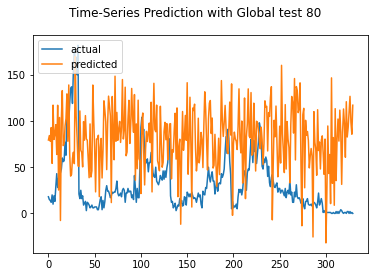

Test MAE: 38.524
Test RMSE: 47.058
Test sMAPE: 94.998
Test R Squared: -1.291
{'mae': 38.523997314229156, 'rmse': 47.05759728091084, 'smape': 94.99756568008182, 'r2': -1.2914031147141949}


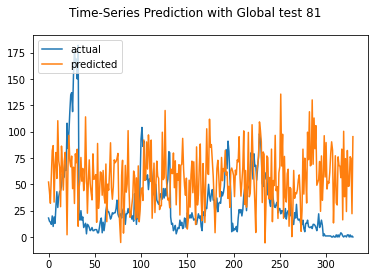

Test MAE: 50.387
Test RMSE: 60.777
Test sMAPE: 105.090
Test R Squared: -2.822
{'mae': 50.38743761669506, 'rmse': 60.77747323781923, 'smape': 105.08952835567959, 'r2': -2.822322115310979}


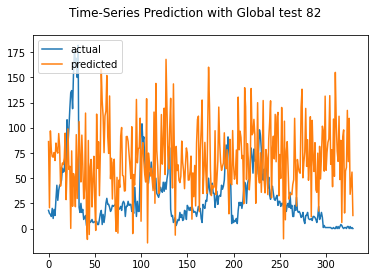

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 43.383
Test RMSE: 55.289
Test sMAPE: 120.975
Test R Squared: -2.163
{'mae': 43.38328386129755, 'rmse': 55.28937152418844, 'smape': 120.97467531430244, 'r2': -2.1631902135141283}


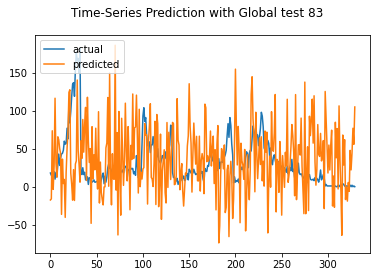

Test MAE: 37.129
Test RMSE: 48.469
Test sMAPE: 101.182
Test R Squared: -1.431
{'mae': 37.12920039260026, 'rmse': 48.46923186014441, 'smape': 101.1820527736843, 'r2': -1.4309402016681703}


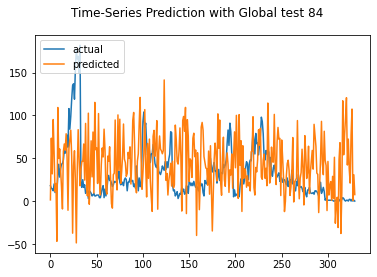

Test MAE: 45.682
Test RMSE: 55.664
Test sMAPE: 103.679
Test R Squared: -2.206
{'mae': 45.68160167471929, 'rmse': 55.66409957205873, 'smape': 103.67935201812344, 'r2': -2.206213055521302}


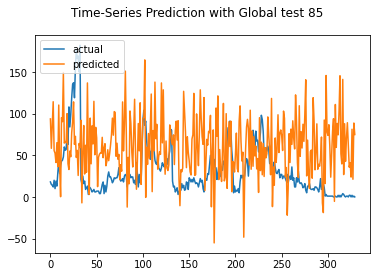

Test MAE: 54.864
Test RMSE: 63.249
Test sMAPE: 108.818
Test R Squared: -3.140
{'mae': 54.863897466659544, 'rmse': 63.24928551086669, 'smape': 108.81753310805328, 'r2': -3.1395511138213195}


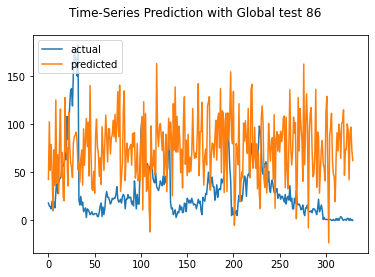

Test MAE: 51.134
Test RMSE: 60.171
Test sMAPE: 105.311
Test R Squared: -2.746
{'mae': 51.134026087414135, 'rmse': 60.1706263251004, 'smape': 105.31146099357478, 'r2': -2.7463734410630294}


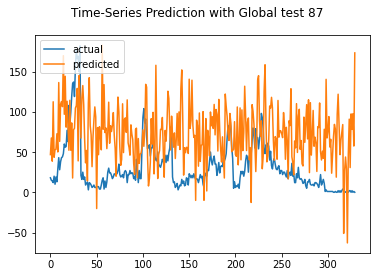

Test MAE: 48.859
Test RMSE: 56.792
Test sMAPE: 104.923
Test R Squared: -2.338
{'mae': 48.85871399026929, 'rmse': 56.79239306857438, 'smape': 104.92282529873407, 'r2': -2.337508186536518}


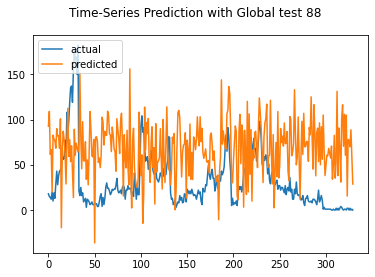

Test MAE: 75.236
Test RMSE: 82.583
Test sMAPE: 119.648
Test R Squared: -6.057
{'mae': 75.23573476328994, 'rmse': 82.5830482870189, 'smape': 119.64786716514914, 'r2': -6.057060172558779}


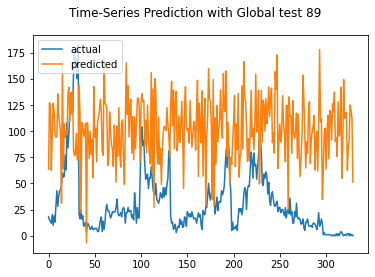

Test MAE: 38.135
Test RMSE: 49.556
Test sMAPE: 120.292
Test R Squared: -1.541
{'mae': 38.134940973104854, 'rmse': 49.556363100780054, 'smape': 120.29217994027643, 'r2': -1.5412117480017167}


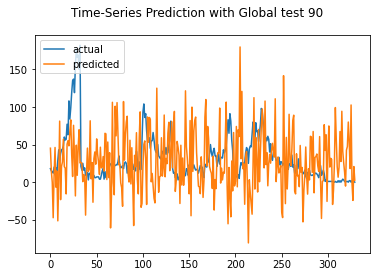

Test MAE: 43.845
Test RMSE: 55.367
Test sMAPE: 103.795
Test R Squared: -2.172
{'mae': 43.844509049256644, 'rmse': 55.36691126679028, 'smape': 103.7950111681524, 'r2': -2.1720687714670466}


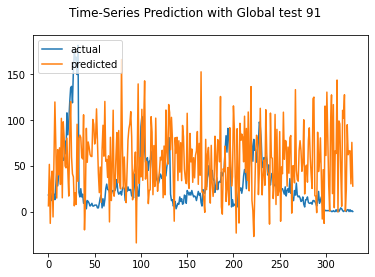

Test MAE: 46.254
Test RMSE: 54.246
Test sMAPE: 103.700
Test R Squared: -2.045
{'mae': 46.254469415274535, 'rmse': 54.24557305254657, 'smape': 103.69981308853156, 'r2': -2.04488296579654}


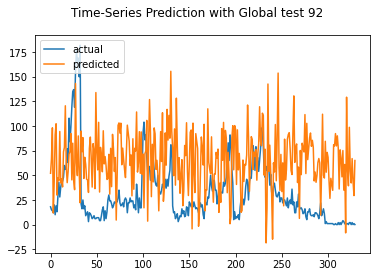

Test MAE: 50.582
Test RMSE: 59.815
Test sMAPE: 105.188
Test R Squared: -2.702
{'mae': 50.58183360533281, 'rmse': 59.814696382561, 'smape': 105.1884023718328, 'r2': -2.7021823575526867}


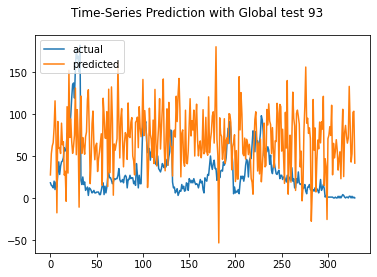

Test MAE: 36.499
Test RMSE: 46.677
Test sMAPE: 99.151
Test R Squared: -1.254
{'mae': 36.49933963363821, 'rmse': 46.67664008253885, 'smape': 99.15072440933288, 'r2': -1.254452945116454}


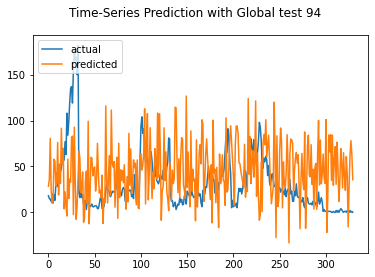

Test MAE: 45.231
Test RMSE: 53.872
Test sMAPE: 102.146
Test R Squared: -2.003
{'mae': 45.230581204818954, 'rmse': 53.87153307572944, 'smape': 102.14571711770819, 'r2': -2.0030369190482196}


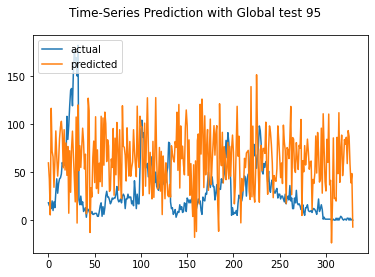

Test MAE: 39.418
Test RMSE: 48.251
Test sMAPE: 95.345
Test R Squared: -1.409
{'mae': 39.418389618758, 'rmse': 48.2514529134948, 'smape': 95.34493781198633, 'r2': -1.4091441786851084}


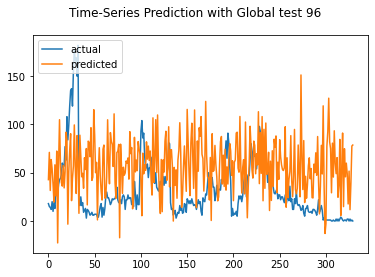

Test MAE: 47.549
Test RMSE: 57.111
Test sMAPE: 103.711
Test R Squared: -2.375
{'mae': 47.549074996962695, 'rmse': 57.11075970093407, 'smape': 103.71072137044861, 'r2': -2.3750318550274336}


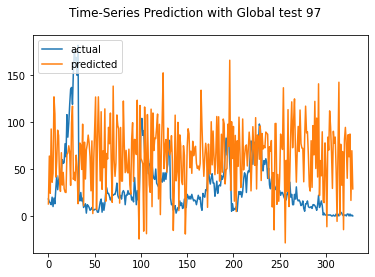

Test MAE: 73.230
Test RMSE: 81.683
Test sMAPE: 119.509
Test R Squared: -5.904
{'mae': 73.23027811556152, 'rmse': 81.6827496278878, 'smape': 119.50920134810171, 'r2': -5.904030463495789}


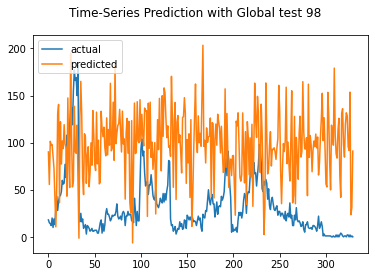

Test MAE: 41.413
Test RMSE: 50.088
Test sMAPE: 97.357
Test R Squared: -1.596
{'mae': 41.41301518931533, 'rmse': 50.08752245828625, 'smape': 97.35701625943629, 'r2': -1.5959785639926767}


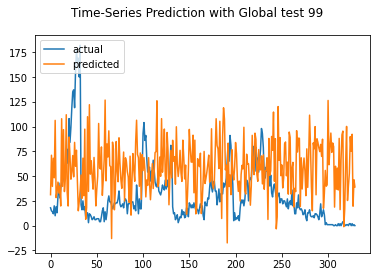

rmse : average=57.686, std=8.393
mae : average=48.320, std=8.658
smape : average=105.222, std=5.662
r2 : average=-2.516, std=1.053


([57.68642029416917, 8.392727693805332],
 [48.32046148091194, 8.657837606647863],
 [105.22159405429305, 5.661500071687241],
 [-2.5163002245462467, 1.0525980978983522])

In [14]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]

calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=None, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')